AttributeError: module 'pandas' has no attribute 'to_csv'

In [51]:
import pandas as pd
URL = "http://people.whitman.edu/~hundledr/courses/M250F03/LynxHare.txt"
data = pd.read_csv(URL, sep=" (?!$)", names=["year", "hare", "lynx"], index_col=0, engine="python")
np.log(data["hare"]).std()

1.1503013848458572

In [42]:
import torch

n = 7
A = torch.randn(n, 2 * n)
L = A.matmul(A.transpose(-1, -2)).cholesky()

def f1(L):
    Linv = torch.inverse(L)
    return torch.matmul(Linv.transpose(-1, -2), Linv)

def f2(L):
    return torch.cholesky_solve(torch.eye(L.size(-1)), L)

assert (f1(L) - f2(L)).max() < 1e-5
%timeit f2(L)
%timeit f1(L)

12.3 µs ± 41.9 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
11.7 µs ± 20.6 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [1]:
import numpyro

In [2]:
numpyro.set_platform('tpu')

In [8]:
import numpy as np

In [19]:
type(np.float64(0))

numpy.float64

In [9]:
x = np.ones(())
x

array(1.)

In [13]:
y = np.random.random(())

In [15]:
np.array(1.)

array(1.)

In [12]:
type(x)

numpy.ndarray

In [11]:
isinstance(x, Number)

False

In [10]:
from numbers import Number

In [7]:
import torch
x = torch.randn(2, 3, 5)
x.permute((2, 0, 1))

tensor([[[ 1.7573, -0.5251,  1.8174],
         [ 0.4143, -0.0605, -0.3052]],

        [[-1.0367, -1.3531, -1.4605],
         [ 0.6322, -1.6254, -1.8012]],

        [[-0.9594, -1.2230,  0.2508],
         [ 0.2698,  0.5484,  0.9322]],

        [[-0.5042,  1.0241,  0.3740],
         [ 0.7313, -0.6418, -0.6320]],

        [[-0.7360,  0.5554,  1.1272],
         [-0.1617,  0.2671, -0.5614]]])

In [3]:
import jax
jax.lib.xla_bridge.get_backend().platform

RuntimeError: Unknown backend tpu

In [2]:
import numpyro

In [3]:
jax.lib.xla_bridge.get_backend().platform

'gpu'

In [4]:
numpyro.set_platform('cpu')
jax.lib.xla_bridge.get_backend().platform

'gpu'

In [1]:
import math
import matplotlib.pyplot as plt
import torch
import pyro
import pyro.distributions as dist
import pyro.contrib.gp as gp
pyro.set_rng_seed(0)

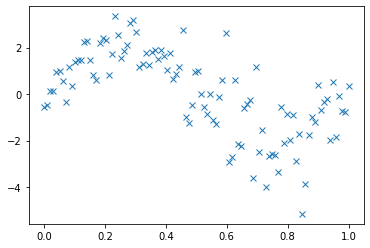

In [2]:
n = 100
x = torch.linspace(0, 1, n)
y = 2 * torch.sin(2 * math.pi * x) + torch.randn(n) * torch.linspace(0.5, 1.5, n)
plt.plot(x, y, "x");

In [3]:
xu = torch.rand(10)

In [52]:
class Constant(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.a = torch.tensor(1.)  #torch.nn.Parameter(torch.tensor(0.))

    def forward(self, x):
        return self.a


class HGP(pyro.nn.PyroModule):
    def __init__(self, x, y, use_mean_function=False, jitter=1e-2):
        super().__init__()
        self.gp_mean = gp.models.VariationalGP(
            x, y, gp.kernels.RBF(1), gp.likelihoods.Gaussian(), whiten=True, jitter=jitter)
        del self.gp_mean.likelihood.variance
        mean_function = None
        if use_mean_function:
            mean_function = Constant()
        self.gp_var = gp.models.VariationalGP(
            x, None, gp.kernels.RBF(1), None, mean_function=mean_function, whiten=True, jitter=jitter)

    def model(self):
        g_loc, g_var = self.gp_var.model()
        g = dist.Normal(g_loc, g_var.sqrt())()
        self.gp_mean.likelihood.variance = g.exp()
        self.gp_mean.model()

    def guide(self):
        self.gp_var.guide()
        self.gp_mean.guide()

    def forward(self, x):
        g_loc, g_var = self.gp_var(x)
        print(g_loc)
        g = dist.Normal(g_loc, g_var.sqrt())()
        f_loc, f_var = self.gp_mean(x)
        return f_loc, f_var, f_var + g.exp()

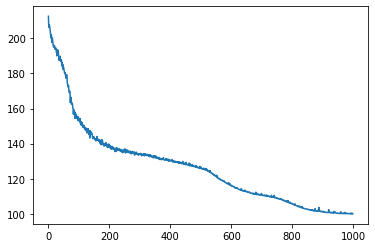

In [56]:
pyro.clear_param_store()
hgp = HGP(x, y, use_mean_function=True, jitter=1e-2)
losses = gp.util.train(hgp, num_steps=1000)
plt.plot(losses);

In [57]:
hgp.gp_var.f_loc

Parameter containing:
tensor([-1.3743e+00, -2.3669e-02, -3.2436e-02, -3.8076e-02, -3.8259e-02,
        -3.4647e-02, -2.9870e-02, -2.3934e-02, -1.9606e-02, -1.5889e-02,
        -1.3802e-02, -1.0394e-02, -8.1830e-03, -6.6184e-03, -6.5824e-03,
        -3.7863e-03, -4.0242e-03, -3.4967e-03, -3.2197e-03, -2.6684e-03,
        -2.8820e-03, -2.6514e-03, -2.5444e-03, -2.5450e-03, -2.3427e-03,
        -2.2327e-03, -2.1615e-03, -2.4265e-03, -2.3086e-03, -1.8765e-03,
        -2.1977e-03, -1.9884e-03, -1.9908e-03, -2.0066e-03, -1.9832e-03,
        -5.2765e-04, -1.6484e-03, -2.2666e-03, -2.2288e-03, -2.2702e-03,
        -2.2494e-03, -2.2553e-03, -2.2416e-03, -2.0480e-03, -2.2137e-03,
        -2.1471e-03, -2.1015e-03, -2.0712e-03, -2.0681e-03, -1.9879e-03,
        -2.7643e-03, -1.7671e-03, -2.8443e-03, -1.5434e-03, -1.5073e-03,
        -1.5346e-03, -1.2518e-03, -1.4603e-03, -1.3453e-03, -1.2918e-03,
        -1.2528e-03, -1.2104e-03, -1.1657e-03, -1.1154e-03, -1.1025e-03,
        -1.0532e-03, -1.3520e

tensor([-14.7242, -14.7269, -14.7294, -14.7319, -14.7342, -14.7364, -14.7385,
        -14.7405, -14.7425, -14.7442, -14.7459, -14.7475, -14.7490, -14.7504,
        -14.7517, -14.7528, -14.7539, -14.7549, -14.7557, -14.7565, -14.7571,
        -14.7576, -14.7581, -14.7584, -14.7586, -14.7587, -14.7587, -14.7586,
        -14.7584, -14.7581, -14.7577, -14.7572, -14.7565, -14.7558, -14.7550,
        -14.7540, -14.7530, -14.7518, -14.7505, -14.7492, -14.7477, -14.7461,
        -14.7444, -14.7426, -14.7407, -14.7387, -14.7366, -14.7344, -14.7321,
        -14.7297, -14.7272, -14.7245, -14.7218, -14.7189, -14.7160, -14.7130,
        -14.7098, -14.7065, -14.7032, -14.6997, -14.6961, -14.6924, -14.6887,
        -14.6848, -14.6808, -14.6767, -14.6725, -14.6682, -14.6638, -14.6592,
        -14.6546, -14.6499, -14.6451, -14.6402, -14.6351, -14.6300, -14.6248,
        -14.6194, -14.6140, -14.6084, -14.6028, -14.5970, -14.5912, -14.5852,
        -14.5792, -14.5730, -14.5667, -14.5604, -14.5539, -14.54

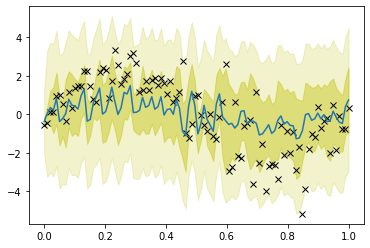

In [58]:
x_new = torch.linspace(0, 1, 100)
with torch.no_grad():
    loc, var, var_sum = hgp(x_new)
    loc = hgp.gp_mean.f_loc
    var = hgp.gp_mean.f_scale_tril.pow(2).sum(-1)
    var_sum = var + (hgp.gp_var.f_loc + hgp.gp_var.mean_function.a).exp()
    plt.plot(x, y, "kx")
    plt.plot(x_new, loc.detach(), "-")
    plt.fill_between(x_new, loc - 2 * var_sum.sqrt(), loc + 2 * var_sum.sqrt(), color="y", alpha=0.2)
    plt.fill_between(x_new, loc - 2 * var.sqrt(), loc + 2 * var.sqrt(), color="y", alpha=0.4)

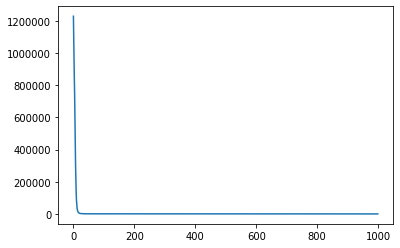

In [15]:
pyro.clear_param_store()
hgp = HGP(x, y, use_mean_function=True, jitter=1e-6)
losses = gp.util.train(hgp)
plt.plot(losses);

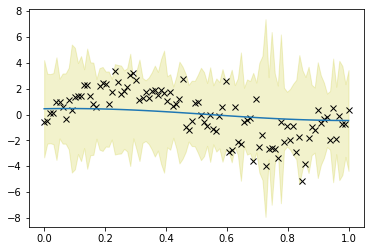

In [16]:
x_new = torch.linspace(0, 1, 100)
with torch.no_grad():
    loc, var = hgp(x_new)
    plt.plot(x, y, "kx")
    plt.plot(x_new, loc, "-")
    plt.fill_between(x_new, loc - 2 * var.sqrt(), loc + 2 * var.sqrt(), color="y", alpha=0.2)